In [4]:
import pyspark
from pyspark.sql import SparkSession

# EXTRACTING

In [3]:
spark = SparkSession.builder.appName("Asteroid1").getOrCreate()
df=spark.read.csv('/content/drive/MyDrive/dataset.csv',header=True,inferSchema=True)

In [5]:
df.show()

+--------+-------+-----------------+----+----------+------+---+---+----+--------+------+--------------+--------+---------+---------+-----------+-------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+
|      id|  spkid|        full_name|pdes|      name|prefix|neo|pha|   H|diameter|albedo|diameter_sigma|orbit_id|    epoch|epoch_mjd|  epoch_cal|equinox|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|                tp|            tp_cal|              per|           per_y|    moid|     moid_ld|   sigma_e|   sigma_a|   sigma_q|  sigma_i| 

# TRANSFORMING

In [6]:
df=df.drop(df['prefix'],df['equinox'])

In [7]:
from pyspark.sql.functions import mean

mean_values = df.select(
    mean('diameter').alias('diameter'),
    mean('diameter_sigma').alias('diameter_sigma'),
    mean('sigma_e').alias('sigma_e'),
    mean('sigma_a').alias('sigma_a'),
    mean('sigma_q').alias('sigma_q'),
    mean('sigma_i').alias('sigma_i'),
    mean('sigma_om').alias('sigma_om'),
    mean('sigma_w').alias('sigma_w'),
    mean('sigma_ma').alias('sigma_ma'),
    mean('sigma_ad').alias('sigma_ad'),
    mean('sigma_n').alias('sigma_n'),
    mean('sigma_tp').alias('sigma_tp'),
    mean('sigma_per').alias('sigma_per'),
    mean('moid').alias('moid'),
    mean('per_y').alias('per_y'),
    mean('per').alias('per'),
    mean('epoch').alias('epoch'),
    mean('epoch_cal').alias('epoch_cal'),
    mean('tp').alias('tp'),
    mean('tp_cal').alias('tp_cal'),
    mean('ad').alias('ad'),
    mean('n').alias('n'),
    mean('ma').alias('ma'),
    mean('w').alias('w'),
    mean('om').alias('om'),
    mean('i').alias('i'),
    mean('q').alias('q'),
    mean('a').alias('a'),
    mean('e').alias('e'),
    mean('H').alias('H'),
    mean('albedo').alias('albedo')
).collect()[0].asDict()

df = df.fillna(mean_values)


In [8]:
df.show()

+--------+-------+-----------------+----+----------+---+---+----+--------+------+-------------------+--------+---------+---------+-----------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+
|      id|  spkid|        full_name|pdes|      name|neo|pha|   H|diameter|albedo|     diameter_sigma|orbit_id|    epoch|epoch_mjd|  epoch_cal|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|                tp|            tp_cal|              per|           per_y|    moid|     moid_ld|   sigma_e|   sigma_a|   sigma_q|  sigma_i| sigma_om|  sigma_w| 

In [9]:
df=df.withColumn('new_q',df['a']*(1-df['e']))
df.show()

+--------+-------+-----------------+----+----------+---+---+----+--------+------+-------------------+--------+---------+---------+-----------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+------------------+
|      id|  spkid|        full_name|pdes|      name|neo|pha|   H|diameter|albedo|     diameter_sigma|orbit_id|    epoch|epoch_mjd|  epoch_cal|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|                tp|            tp_cal|              per|           per_y|    moid|     moid_ld|   sigma_e|   sigma_a|   sigma_q|  sigma_i| s

In [10]:
df=df.withColumn('error_q',(df['q']-df['new_q'])*100)
df.show()

+--------+-------+-----------------+----+----------+---+---+----+--------+------+-------------------+--------+---------+---------+-----------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+------------------+--------------------+
|      id|  spkid|        full_name|pdes|      name|neo|pha|   H|diameter|albedo|     diameter_sigma|orbit_id|    epoch|epoch_mjd|  epoch_cal|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|                tp|            tp_cal|              per|           per_y|    moid|     moid_ld|   sigma_e|   sigma_a|  

In [11]:
from pyspark.sql.functions import mean, avg

print(df.select(avg('error_q')).collect()[0][0])

-3.5643732109649807e-10


In [12]:
from pyspark.sql.functions import col, when,concat,lit

df = df.withColumn(
    'Orbit_ID',
    when(col('Orbit_ID').contains('JPL'), col('Orbit_ID'))
    .otherwise(concat(lit('JPL'),lit(' '), col('Orbit_ID')))
)


In [13]:
df.show()

+--------+-------+-----------------+----+----------+---+---+----+--------+------+-------------------+--------+---------+---------+-----------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+------------------+--------------------+
|      id|  spkid|        full_name|pdes|      name|neo|pha|   H|diameter|albedo|     diameter_sigma|Orbit_ID|    epoch|epoch_mjd|  epoch_cal|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|                tp|            tp_cal|              per|           per_y|    moid|     moid_ld|   sigma_e|   sigma_a|  

In [14]:
from pyspark.sql.functions import col, sqrt

df = df.withColumn('orbital_shape', col('a') * col('e'))
df = df.withColumn('risk_index', col('diameter') / (col('moid') * col('q')))
df = df.withColumn('uncertainty_index', sqrt(col('sigma_a')**2 + col('sigma_e')**2 + col('sigma_i')**2))


In [15]:
df.show()

+--------+-------+-----------------+----+----------+---+---+----+--------+------+-------------------+--------+---------+---------+-----------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+------------------+--------------------+-------------------+------------------+--------------------+
|      id|  spkid|        full_name|pdes|      name|neo|pha|   H|diameter|albedo|     diameter_sigma|Orbit_ID|    epoch|epoch_mjd|  epoch_cal|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|                tp|            tp_cal|              per|   

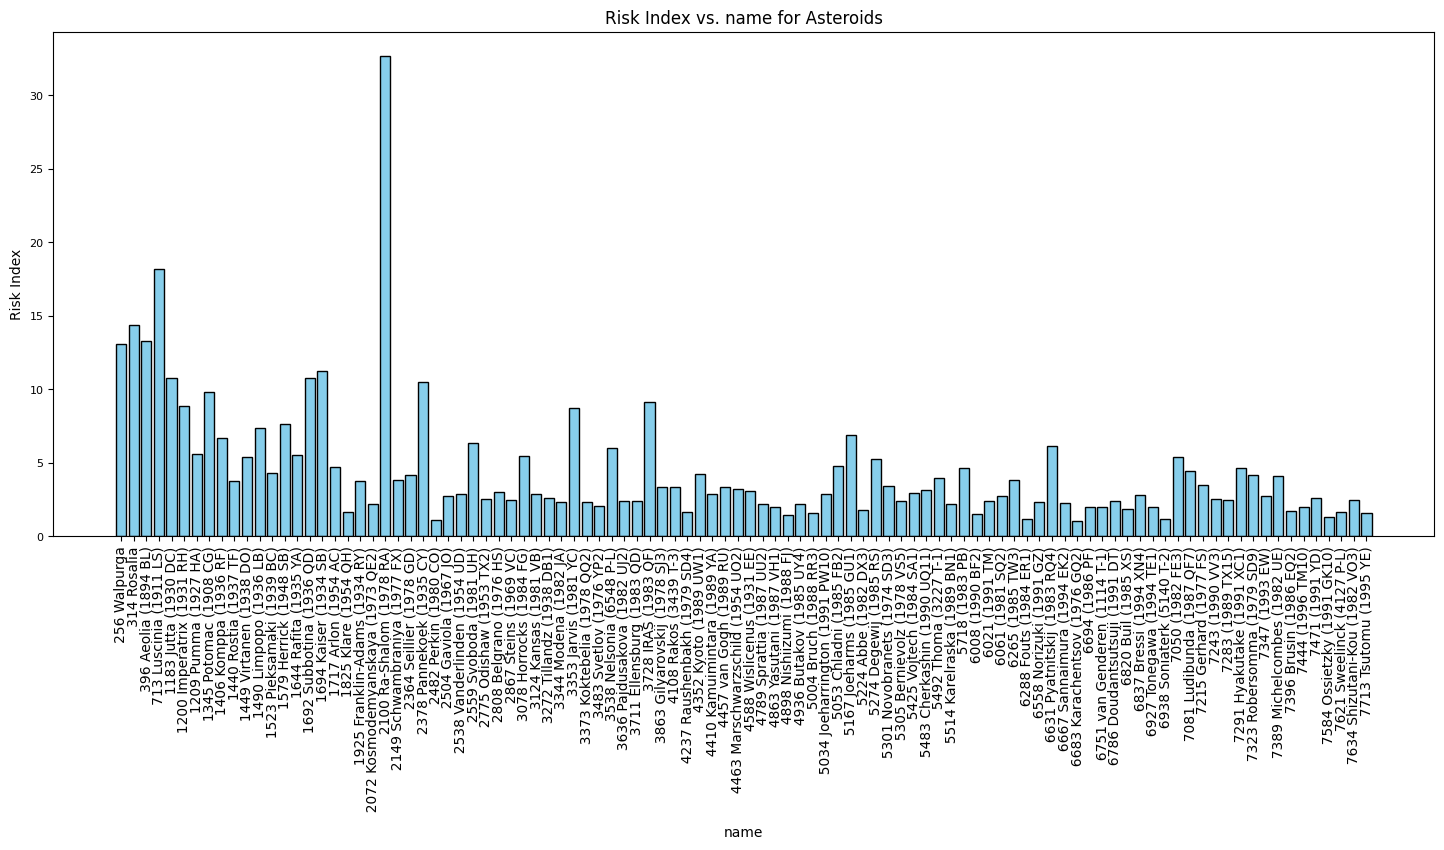

In [16]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

df_sample = df.select('full_name', 'risk_index').sample(fraction=0.01,seed=42).limit(100)

pandas_df = df_sample.toPandas()

plt.figure(figsize=(15, 6))
plt.bar(pandas_df['full_name'], pandas_df['risk_index'], color='skyblue', edgecolor='black')
plt.xlabel('name')
plt.ylabel('Risk Index')
plt.title('Risk Index vs. name for Asteroids')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

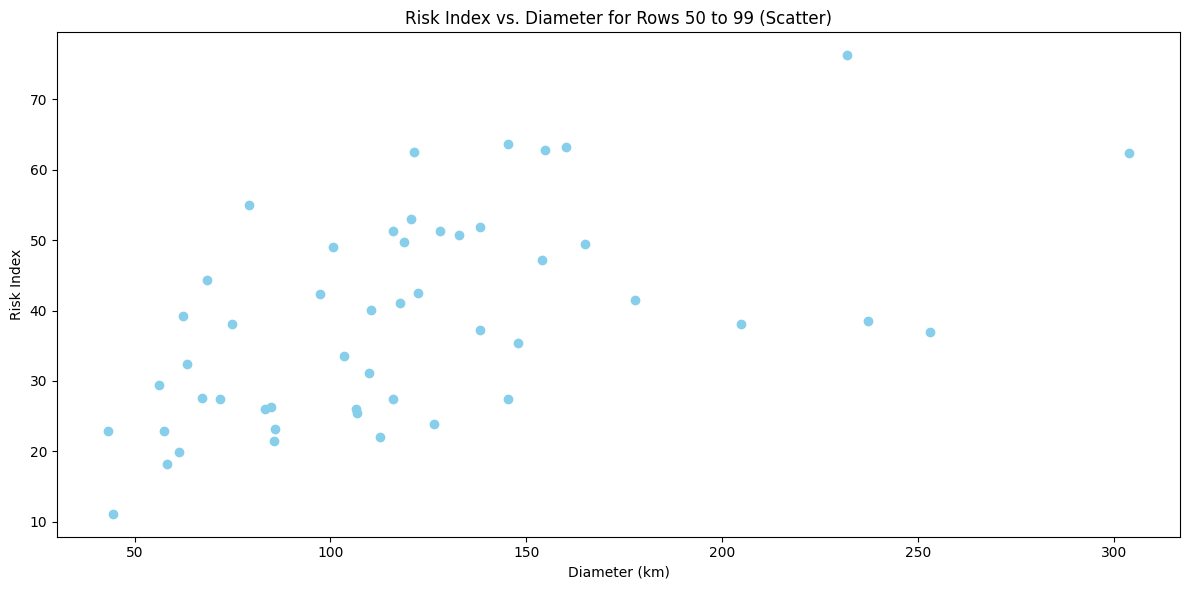

In [17]:
from pyspark.sql.functions import col, monotonically_increasing_id
import pandas as pd
import matplotlib.pyplot as plt

df_with_index = df.withColumn('row_index', monotonically_increasing_id())

df_sorted = df_with_index.orderBy('id')

df_slice = df_sorted.filter((col('row_index') >= 50) & (col('row_index') < 100))

df_slice = df_slice.select('diameter', 'risk_index')

pandas_df = df_slice.toPandas()


plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['diameter'], pandas_df['risk_index'], color='skyblue')
plt.xlabel('Diameter (km)')
plt.ylabel('Risk Index')
plt.title('Risk Index vs. Diameter for Rows 50 to 99 (Scatter)')
plt.tight_layout()
plt.show()

In [18]:
new_df=df.sort(col('risk_index').desc())
new_df=df.drop('name')
new_df.show()

+--------+-------+-----------------+----+---+---+----+--------+------+-------------------+--------+---------+---------+-----------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+------------------+--------------------+-------------------+------------------+--------------------+
|      id|  spkid|        full_name|pdes|neo|pha|   H|diameter|albedo|     diameter_sigma|Orbit_ID|    epoch|epoch_mjd|  epoch_cal|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|                tp|            tp_cal|              per|           per_y|    moid

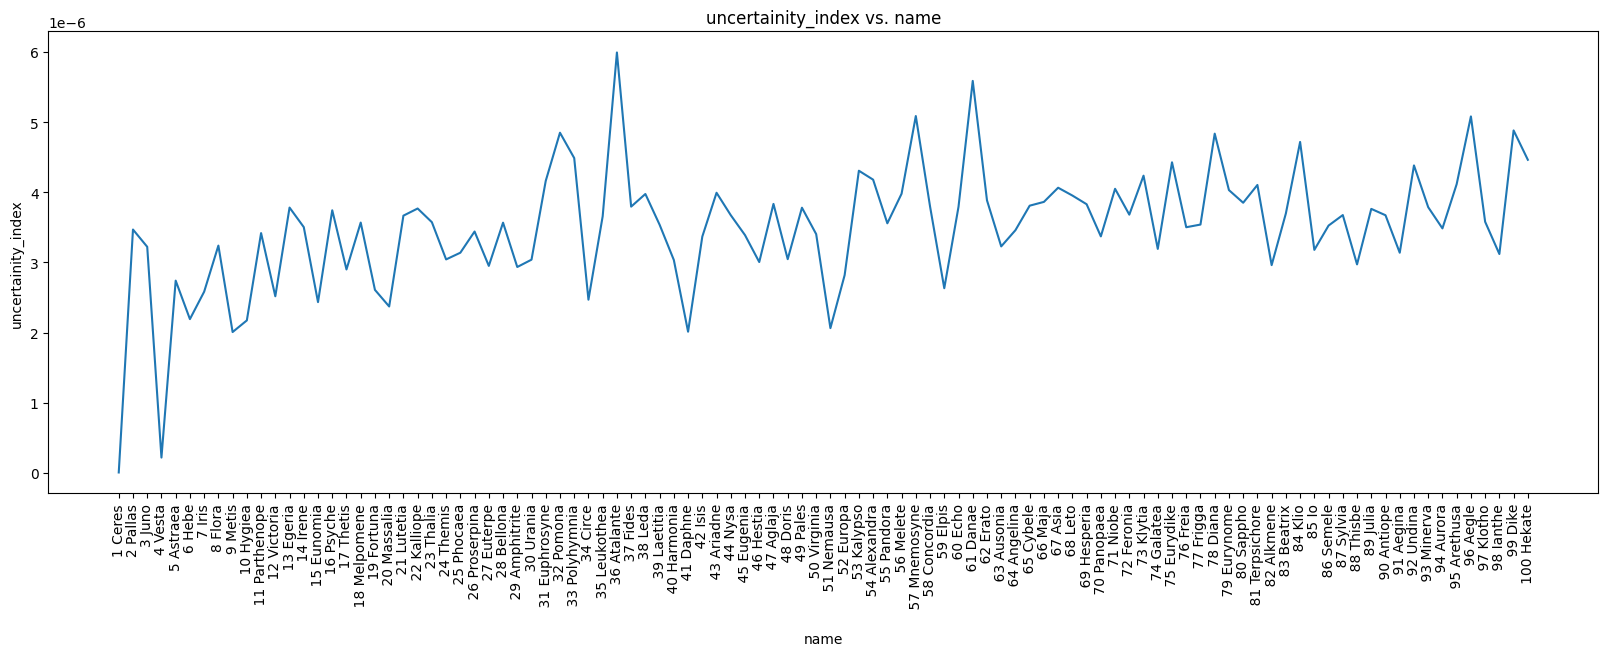

In [19]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt

df_sample = new_df.select('full_name', 'uncertainty_index').limit(100)
pandas_df = df_sample.toPandas()

plt.figure(figsize=(20, 6))
plt.plot(pandas_df['full_name'],pandas_df['uncertainty_index'])
plt.xlabel('name')
plt.ylabel('uncertainity_index')
plt.title('uncertainity_index vs. name')
plt.xticks(rotation=90)
plt.show()

In [20]:
df=df.drop(df['epoch'],df['epoch_cal'],df['tp'],df['tp_cal'],df['diameter_sigma'])
df.show()

+--------+-------+-----------------+----+----------+---+---+----+--------+------+--------+---------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+------------------+--------------------+-------------------+------------------+--------------------+
|      id|  spkid|        full_name|pdes|      name|neo|pha|   H|diameter|albedo|Orbit_ID|epoch_mjd|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|              per|           per_y|    moid|     moid_ld|   sigma_e|   sigma_a|   sigma_q|  sigma_i| sigma_om|  sigma_w| sigma_ma|  sigma_ad|   sigma_n| sigma_tp|sigma_per|class|   

In [21]:
new_df=new_df.drop(new_df['epoch'],new_df['epoch_cal'],new_df['tp'],new_df['tp_cal'],new_df['diameter_sigma'])
new_df.show()

+--------+-------+-----------------+----+---+---+----+--------+------+--------+---------+-------------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+--------+------------+----------+----------+----------+---------+---------+---------+---------+----------+----------+---------+---------+-----+-------+------------------+--------------------+-------------------+------------------+--------------------+
|      id|  spkid|        full_name|pdes|neo|pha|   H|diameter|albedo|Orbit_ID|epoch_mjd|                  e|                a|                q|                 i|               om|                w|               ma|               ad|                 n|              per|           per_y|    moid|     moid_ld|   sigma_e|   sigma_a|   sigma_q|  sigma_i| sigma_om|  sigma_w| sigma_ma|  sigma_ad|   sigma_n| sigma_tp|sigma_per|class|    rms|             new_

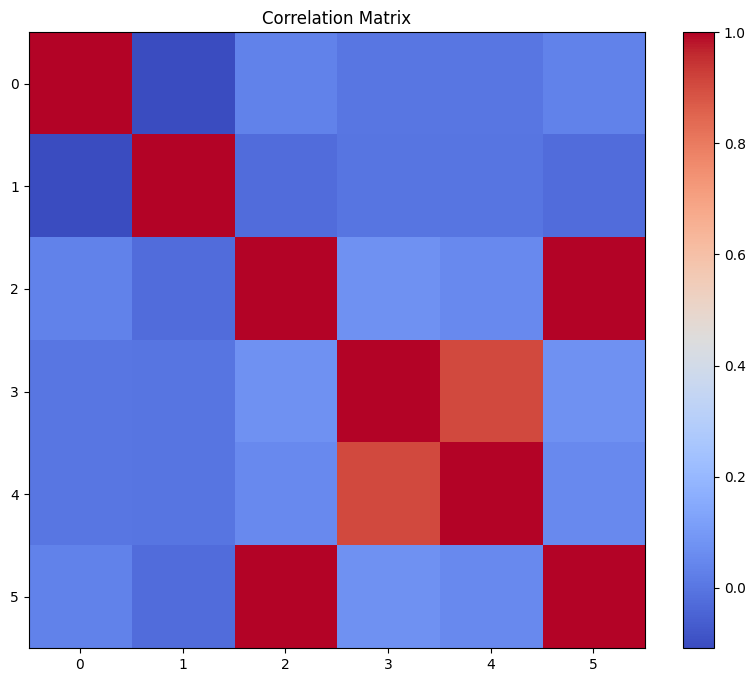

In [22]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt # Ensure matplotlib is imported

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=["diameter", "albedo", "q", "a", "ad", "moid"], outputCol=vector_col)
corr_df = assembler.transform(df).select(vector_col)
correlation_matrix = Correlation.corr(corr_df, vector_col, "pearson").collect()[0][0]

# Convert the DenseMatrix to a NumPy array
correlation_matrix_np = correlation_matrix.toArray()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix_np, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.show() # Add plt.show() to display the plot

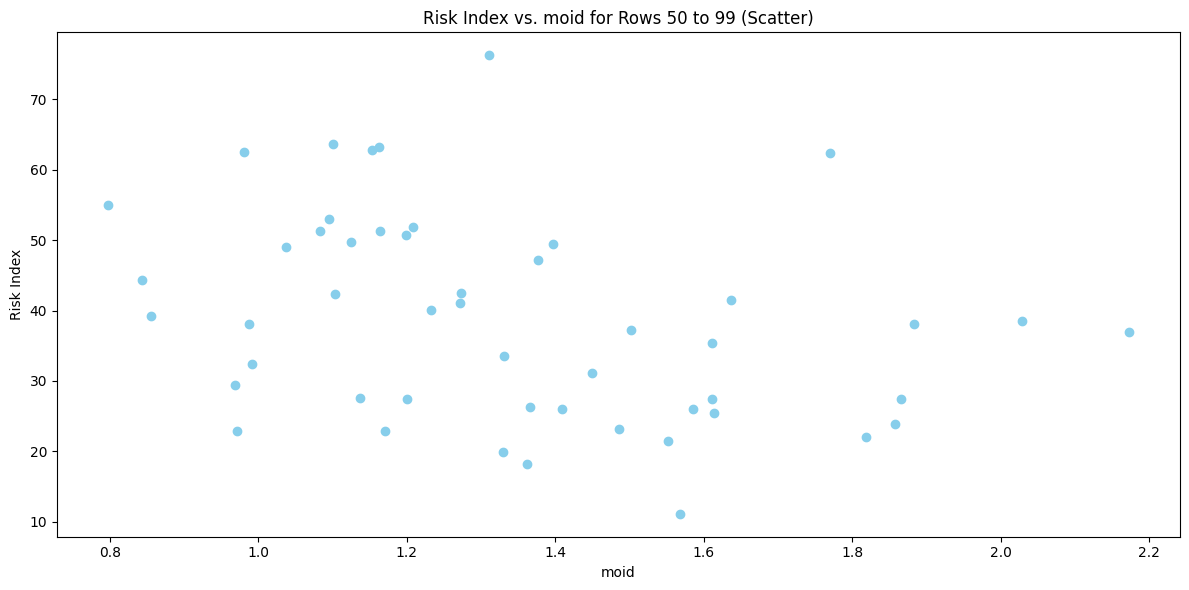

In [23]:
from pyspark.sql.functions import col, monotonically_increasing_id
import pandas as pd
import matplotlib.pyplot as plt

df_with_index = new_df.withColumn('row_index', monotonically_increasing_id())

df_sorted = df_with_index.orderBy('id')

df_slice = df_sorted.filter((col('row_index') >= 50) & (col('row_index') < 100))

df_slice = df_slice.select('moid', 'risk_index')

pandas_df = df_slice.toPandas()


plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['moid'], pandas_df['risk_index'], color='skyblue')
plt.xlabel('moid')
plt.ylabel('Risk Index')
plt.title('Risk Index vs. moid for Rows 50 to 99 (Scatter)')
plt.tight_layout()
plt.show()

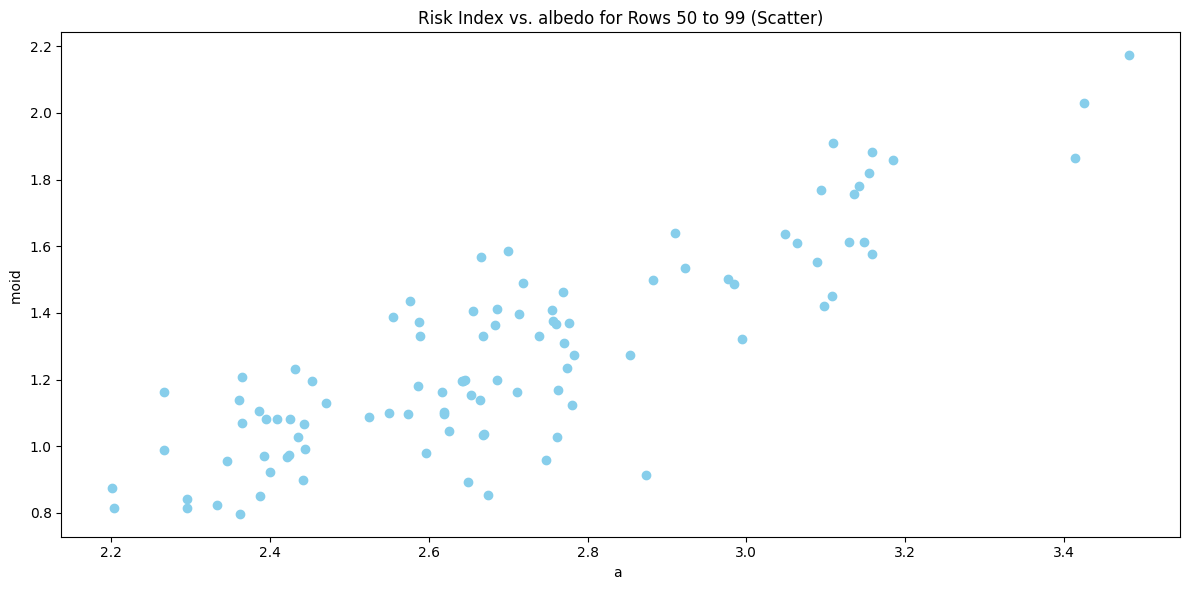

In [24]:
from pyspark.sql.functions import col, monotonically_increasing_id
import pandas as pd
import matplotlib.pyplot as plt

df_with_index = df.withColumn('row_index', monotonically_increasing_id())

df_sorted = df_with_index.orderBy('id')

df_slice = df_sorted.filter((col('row_index') >= 1) & (col('row_index') < 100))

df_slice = df_slice.select('a', 'moid')

pandas_df = df_slice.toPandas()


plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['a'], pandas_df['moid'], color='skyblue')
plt.xlabel('a ')
plt.ylabel('moid ')
plt.title('Risk Index vs. albedo for Rows 50 to 99 (Scatter)')
plt.tight_layout()
plt.show()

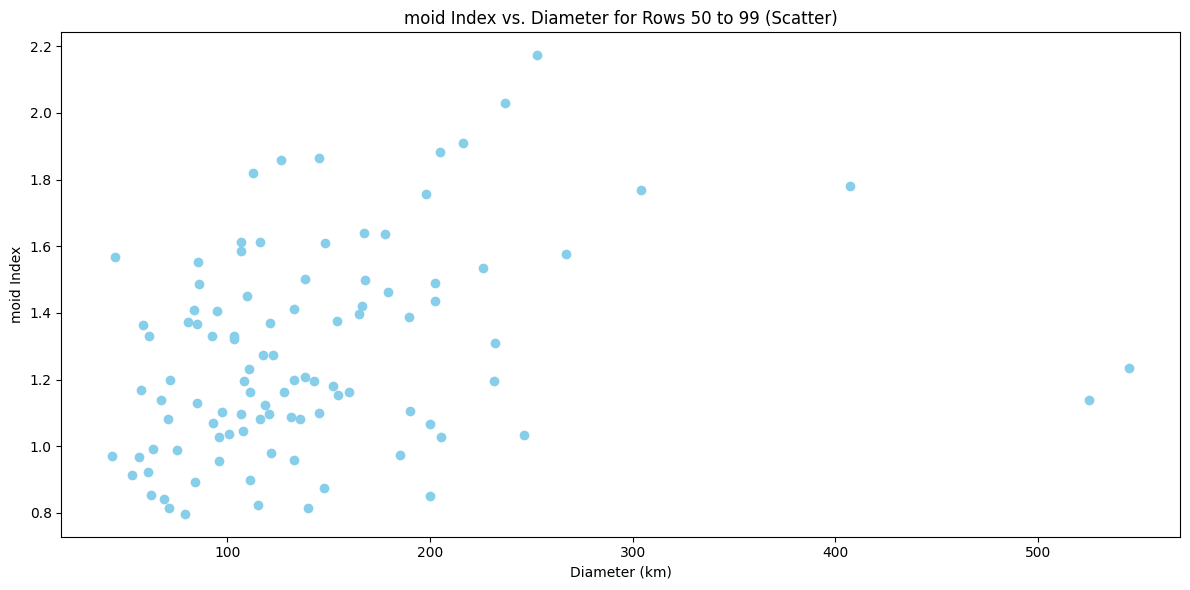

In [25]:
from pyspark.sql.functions import col, monotonically_increasing_id
import pandas as pd
import matplotlib.pyplot as plt

df_with_index = df.withColumn('row_index', monotonically_increasing_id())

df_sorted = df_with_index.orderBy('id')

df_slice = df_sorted.filter((col('row_index') >= 1) & (col('row_index') < 100))

df_slice = df_slice.select('diameter', 'moid')

pandas_df = df_slice.toPandas()


plt.figure(figsize=(12, 6))
plt.scatter(pandas_df['diameter'], pandas_df['moid'], color='skyblue')
plt.xlabel('Diameter (km)')
plt.ylabel('moid Index')
plt.title('moid Index vs. Diameter for Rows 50 to 99 (Scatter)')
plt.tight_layout()
plt.show()

## Regression Analysis: Here below 'moid' is the target variable because it identifies the hazardous nature of asteroids based on other depenedent parameters .
## The parameters below are taken so considering the accuracy and proper contribution to 'moid'

In [26]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

sub_df=df.select('H','diameter','q','moid')
assembler = VectorAssembler(inputCols=['H','diameter','q','moid'],outputCol="features")

assembled_df = assembler.transform(sub_df).select("features", "moid")

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_df)
scaled_data = scaler_model.transform(assembled_df)

train_data, test_data = scaled_data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(featuresCol="features", labelCol="moid", numTrees=100,maxDepth=10)

pipeline = Pipeline(stages=[assembler, scaler, rf])
train_data, test_data = sub_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="moid", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"RMSE: {rmse}")
eval_2=evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2: {eval_2}")


RMSE: 1.2668610841032952
R2: 0.6417385688929542


### Introducing Normalization and Outlier handing for btter performance of madel

In [27]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, expr

sub_df = df.select('H', 'diameter', 'q', 'moid')

def remove_outliers_iqr(df, cols):
    for col_name in cols:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df.filter((col(col_name) >= lower) & (col(col_name) <= upper))
    return df

filtered_df = remove_outliers_iqr(sub_df, ['H', 'diameter', 'q', 'moid'])

assembler = VectorAssembler(inputCols=['H', 'diameter', 'q'], outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="moid", numTrees=100, maxDepth=10)

train_data, test_data = filtered_df.randomSplit([0.8, 0.2], seed=42)

pipeline = Pipeline(stages=[assembler, scaler, rf])

model = pipeline.fit(train_data)
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="moid", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2: {r2}")


RMSE: 0.19709624622104213
R2: 0.7050046785459751


In [28]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

sub_df = df.select('H', 'diameter', 'q', 'moid')

assembler = VectorAssembler(
    inputCols=['H', 'diameter', 'q'],
    outputCol='features'
)

scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

gbt = GBTRegressor(
    featuresCol='scaled_features',
    labelCol='moid',
    maxIter=100,
    maxDepth=10
)

pipeline = Pipeline(stages=[assembler, scaler, gbt])

train_data, test_data = sub_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = RegressionEvaluator(
    labelCol="moid", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2: {r2}")


RMSE: 0.7062654014792306
R2: 0.8886531517730741


In [29]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, expr

sub_df = df.select('H', 'diameter', 'q', 'moid')

def remove_outliers_iqr(df, cols):
    for col_name in cols:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df.filter((col(col_name) >= lower) & (col(col_name) <= upper))
    return df

filtered_df = remove_outliers_iqr(sub_df, ['H', 'diameter', 'q', 'moid'])

assembler = VectorAssembler(inputCols=['H', 'diameter', 'q'], outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
gbt = GBTRegressor(
    featuresCol='scaled_features',
    labelCol='moid',
    maxIter=100,
    maxDepth=10
)
train_data, test_data = filtered_df.randomSplit([0.8, 0.2], seed=42)

pipeline = Pipeline(stages=[assembler, scaler, gbt])

model = pipeline.fit(train_data)
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="moid", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R2: {r2}")


RMSE: 0.07007047996304269
R2: 0.9627154756741493


## As we can see above the performance of data on GBTRegressor is better than Random Forest regressor

## Classification Analysis: Here below we use binary class 'neo' which would classify the asteroid nature based on contributing parameters

In [33]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Step 1: Select required columns
sub_df = df.select('diameter', 'H', 'moid', 'neo')

# Add a step to drop rows where 'neo' is null
sub_df = sub_df.na.drop(subset=['neo'])

# Step 2: Ensure target is numeric (convert 'neo' to binary: 1 if 'Y', else 0)
sub_df = sub_df.withColumn("label", (col("neo") == 'Y').cast("int"))

# Step 3: Assemble features into a single vector
assembler = VectorAssembler(inputCols=['diameter', 'H', 'moid'], outputCol="features")

# Step 4: Normalize features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Step 5: Initialize RandomForestClassifier
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", numTrees=100, maxDepth=10)

# Step 6: Build Pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Step 7: Train-test split
# Use the filtered sub_df for splitting
train_data, test_data = sub_df.randomSplit([0.8, 0.2], seed=42)

# Step 8: Train the model
model = pipeline.fit(train_data)

# Step 9: Make predictions
predictions = model.transform(test_data)

# Step 10: Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Optional: F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1}")

Accuracy: 0.9935869361196271
F1 Score: 0.9936425464357909


In [36]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

sub_df = df.select('diameter', 'H', 'moid', 'neo','a','e','q')

sub_df = sub_df.na.drop(subset=['neo'])

sub_df = sub_df.withColumn("label", (col("neo") == 'Y').cast("int"))

assembler = VectorAssembler(inputCols=['diameter', 'H', 'moid','a','e','q'], outputCol="features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", numTrees=100, maxDepth=10)

pipeline = Pipeline(stages=[assembler, scaler, rf])

train_data, test_data = sub_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1}")

Accuracy: 0.9964441385638908
F1 Score: 0.996475684850096


In [37]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

sub_df = df.select('diameter', 'H', 'moid', 'neo','a','e','q')

sub_df = sub_df.na.drop(subset=['neo'])

sub_df = sub_df.withColumn("label", (col("neo") == 'Y').cast("int"))

assembler = VectorAssembler(inputCols=['diameter', 'H', 'moid','a','e','q'], outputCol="features")

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

gbt= GBTClassifier(featuresCol="scaled_features", labelCol="label", maxIter=100, maxDepth=10)


pipeline = Pipeline(stages=[assembler, scaler, gbt])

train_data, test_data = sub_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1}")

Accuracy: 0.9967569709482992
F1 Score: 0.9967957353057701


### Here too we can see GBTClassifier performs better than Random Forest Classifier

### Now finally extracting only meaning parameters for asteroid analysis and loading it

# LOADING

In [43]:
ext_df = df.select(
    df['full_name'],
    df['neo'],
    df['pha'],
    df['H'],
    df['diameter'],
    df['a'],
    df['e'],
    df['i'],
    df['q'],
    df['moid'],
    df['sigma_a'],
    df['sigma_e'],
    df['sigma_i'],
    df['sigma_q'],
    df['risk_index']
)
ext_df.write.option("header", True).mode("overwrite").csv("output/final_dataset_csv")

spark.catalog.clearCache()

ext_df_loaded = spark.read.option("header", True).option("inferSchema", True).csv("output/final_dataset_csv")
ext_df_loaded.show()

+------------------+---+---+----+------------------+-----------------+-------------------+-----------------+-----------------+-------+---------+---------+---------+---------+------------------+
|         full_name|neo|pha|   H|          diameter|                a|                  e|                i|                q|   moid|  sigma_a|  sigma_e|  sigma_i|  sigma_q|        risk_index|
+------------------+---+---+----+------------------+-----------------+-------------------+-----------------+-----------------+-------+---------+---------+---------+---------+------------------+
| 276489 (2003 PA2)|  N|  N|16.4|5.5064290575513635|2.651894894183055|  0.238066958954722|7.199121148739347|2.020566341257341|1.01296|1.5466E-8|5.8955E-8| 6.783E-6|1.5759E-7| 2.690324322276428|
|276490 (2003 PK11)|  N|  N|15.6|             5.285|3.049033765159188|  0.215276508217912|12.59631374598095|2.392648422757205|1.38718|3.1129E-8|8.3949E-8|8.8286E-6|2.6726E-7| 1.592330761833465|
| 276491 (2003 QK4)|  N|  N|16